In [276]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [277]:
print("Num GPUs Available: ", tf.config.list_physical_devices())

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [278]:
class SVAE(tf.keras.Model):

    def __init__(self, input_dim, latent_dim, output_dim, num_classes):
        super(SVAE, self).__init__()
        self.latent_dim = latent_dim

        # Input
        Input_data = tf.keras.layers.Input(shape = input_dim)
        # Image to vec
        # vec + lable to mu and log_var
        x = tf.keras.layers.Dense(500, activation='relu')(Input_data)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(500, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(500, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        encoded = tf.keras.layers.Dense(latent_dim + latent_dim)(x)
        self.encoder = tf.keras.Model(inputs=[Input_data], outputs=[encoded])

        # hidden space to vec
        embedd = tf.keras.layers.Input((self.latent_dim,))
        x = tf.keras.layers.Dense(500, activation='relu')(embedd)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(500, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(500, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(output_dim, activation='linear')(x)
        x = tf.keras.layers.Reshape(target_shape=input_dim)(x)
        self.decoder = tf.keras.Model(inputs=[embedd], outputs=[x])

        # Classification from Representation
        self.rep_mlp = tf.keras.Sequential([tf.keras.layers.Input(shape = (latent_dim,)), 
                                       tf.keras.layers.Dense(100, activation='relu'), 
                                       tf.keras.layers.Dense(100, activation='relu'), 
                                       tf.keras.layers.Dense(num_classes, activation='softmax'), 
                                       ])


    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder([x]), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        logits = self.decoder([z])
        return logits

    def forward(self, data):
        mean, logvar = self.encode(data)
        z = self.reparameterize(mean, logvar)
        classification = self.rep_mlp(z)
        reconstruction = self.decode(z)
        return(reconstruction, classification)

    @tf.function
    def new_loss (self, real_data, recons, label, pred, landa):
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(real_data, recons)
        latent_loss = tf.keras.losses.sparse_categorical_crossentropy(label, pred)
        return(landa * reconstruction_loss + (1-landa) * latent_loss)

    def compile(self, optimizer, metrics):
        super(SVAE, self).compile(optimizer=optimizer, metrics=metrics)
        self.loss = self.new_loss

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            recons, rep_pred = self.forward(x)
            loss = self.loss(x, recons, y, rep_pred, 0.5)

        training_vars = self.trainable_variables
        gradients = tape.gradient(loss, training_vars)

        self.optimizer.apply_gradients(zip(gradients, training_vars))

        self.compiled_metrics.update_state(x, recons)

        log = {m.name: m.result() for m in self.metrics}
        log['loss'] = loss

        return  log

In [279]:
df = pd.read_csv("data.csv")
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [280]:
label = df["Bankrupt?"]
df.drop(columns=["Bankrupt?"], inplace=True)
df

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,0.781588,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,0.781586,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,0.781546,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,0.781663,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 95 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 1    ROA(A) before interest and % after tax                   6819 non-null   float64
 2    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 3    Operating Gross Margin                                   6819 non-null   float64
 4    Realized Sales Gross Margin                              6819 non-null   float64
 5    Operating Profit Rate                                    6819 non-null   float64
 6    Pre-tax net Interest Rate                                6819 non-null   float64
 7    After-tax net Interest Rate                              6819 non-null   float64
 8    Non-industry inco

In [282]:
df.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,0.012679,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,0.781567,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,0.781635,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,0.781735,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [283]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.2, random_state=0, shuffle=True, stratify=label)
X_train.reset_index(drop=True, inplace = True)
X_test.reset_index(drop=True, inplace = True)

In [284]:
from sklearn.preprocessing import StandardScaler

learn_scaler=StandardScaler().fit(X_train)
X_train_normal = learn_scaler.transform(X_train)
X_test_normal = learn_scaler.transform(X_test)

In [285]:
svae_ = SVAE((95,), 20, 95, 2)
svae_.compile(optimizer='adam', 
              metrics=['mse'])


In [286]:
BatchSize = 100
num_bat_per_epoch = int(X_train_normal.shape[0]/BatchSize)
train_length = BatchSize * num_bat_per_epoch

history = svae_.fit(
    X_train_normal[:train_length], y_train[:train_length],
    batch_size=BatchSize,
    epochs=50,
    verbose="auto",
    callbacks=None,
    validation_split=None,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    )

Epoch 1/50


C:\Users\Hosein\AppData\Local\Temp\ipykernel_4648\194981776.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_train_normal[:train_length], y_train[:train_length],


54/54 [==============================] - 4s 20ms/step - mse: 0.8998 - loss: 0.5227
Epoch 2/50
54/54 [==============================] - 1s 22ms/step - mse: 0.7264 - loss: 0.4118
Epoch 3/50
54/54 [==============================] - 1s 21ms/step - mse: 0.6788 - loss: 0.3844
Epoch 4/50
54/54 [==============================] - 1s 20ms/step - mse: 0.6248 - loss: 0.3476
Epoch 5/50
54/54 [==============================] - 1s 21ms/step - mse: 0.5586 - loss: 0.3141
Epoch 6/50
54/54 [==============================] - 1s 20ms/step - mse: 0.5117 - loss: 0.2870
Epoch 7/50
54/54 [==============================] - 1s 19ms/step - mse: 0.5390 - loss: 0.2998
Epoch 8/50
54/54 [==============================] - 1s 19ms/step - mse: 0.4808 - loss: 0.2691
Epoch 9/50
54/54 [==============================] - 1s 19ms/step - mse: 0.4876 - loss: 0.2691
Epoch 10/50
54/54 [==============================] - 1s 19ms/step - mse: 0.4365 - loss: 0.2423
Epoch 11/50
54/54 [==============================] - 1s 19ms/step - ms

In [287]:
# import matplotlib.pyplot as plt

# plt.plot(history.history["loss"], label="Training Loss")
# plt.legend()

In [288]:
mean, logvar = svae_.encode(X_train_normal)
z = svae_.reparameterize(mean, logvar)
classification = svae_.rep_mlp(z)
reconstruction = svae_.decode(z)

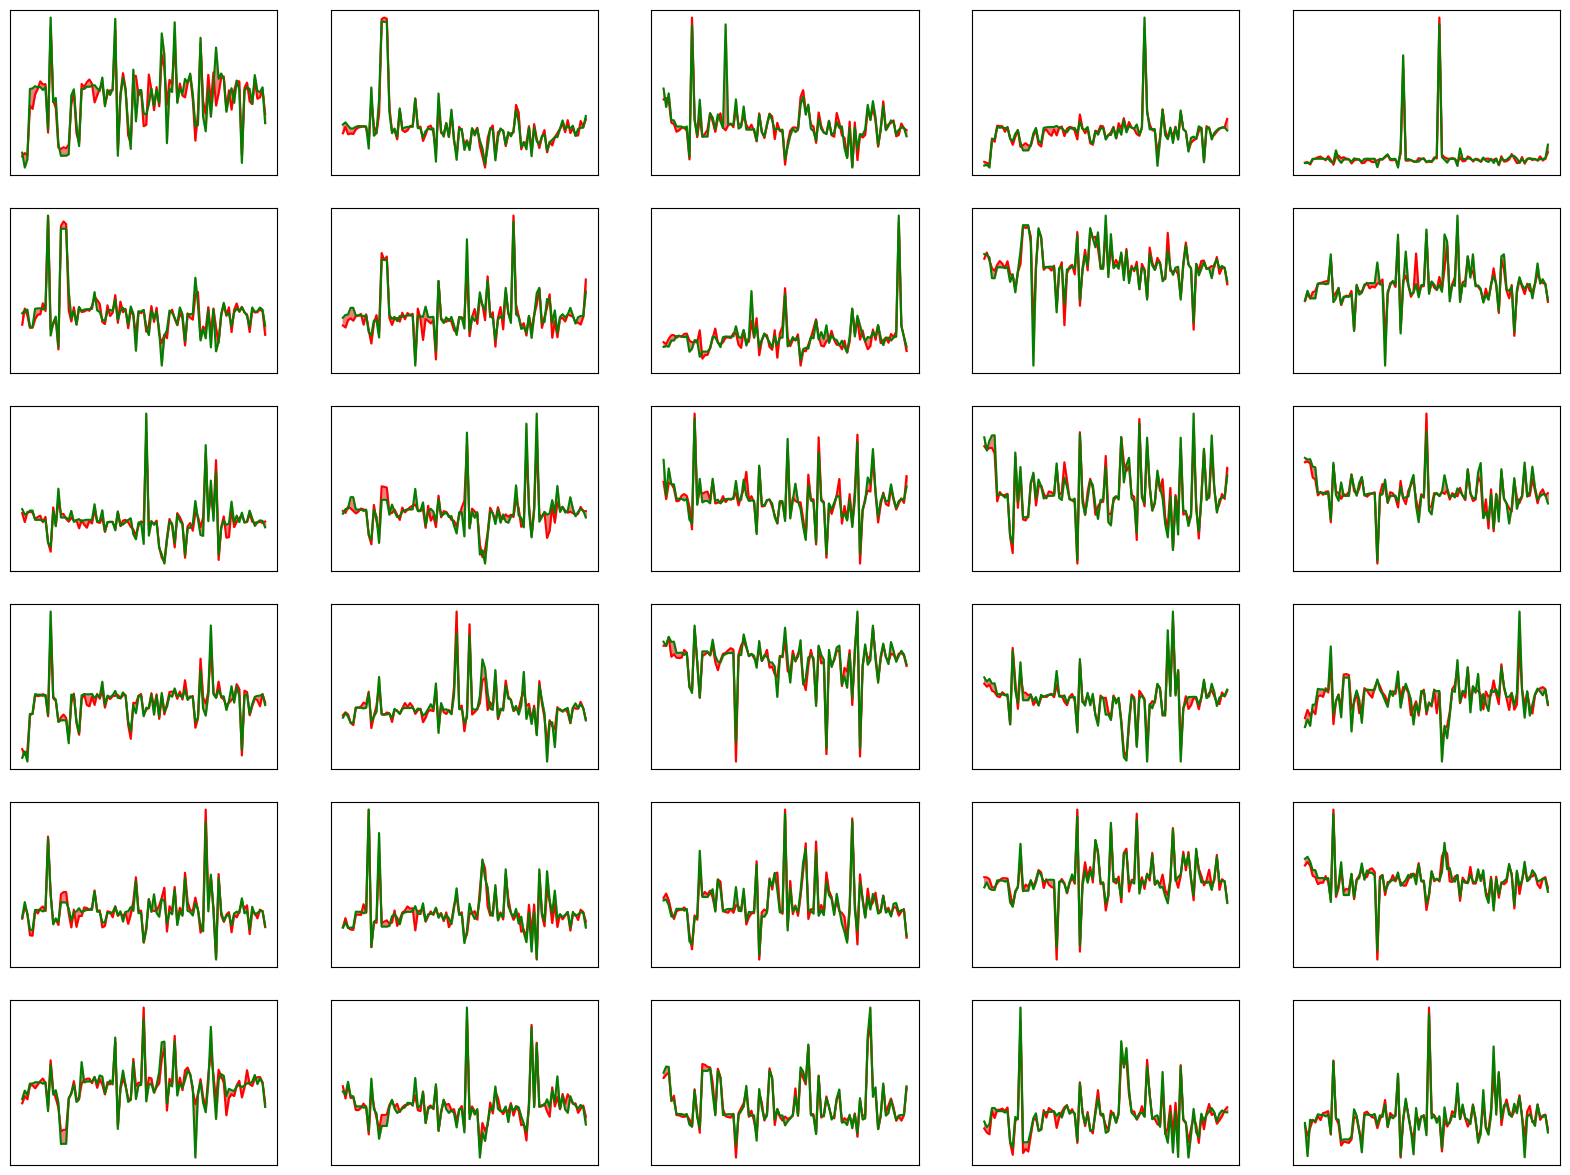

In [289]:
figure = plt.figure(figsize=(20, 15))
for label_index in range(30):
    ax = figure.add_subplot(6, 5, label_index + 1, xticks=[], yticks=[])
    ax.plot(reconstruction[label_index], 'r')
    ax.plot(X_train_normal[label_index], 'g')
    ax.fill_between(np.arange(X_train_normal.shape[1]), X_train_normal[label_index], reconstruction[label_index], color='lightcoral')

In [290]:
y_pred = np.where(classification[:,1] > 0.5, 1, 0)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5279
           1       0.98      0.96      0.97       176

    accuracy                           1.00      5455
   macro avg       0.99      0.98      0.99      5455
weighted avg       1.00      1.00      1.00      5455



In [291]:
mean, logvar = svae_.encode(X_test_normal)
z = svae_.reparameterize(mean, logvar)
classification = svae_.rep_mlp(z)
reconstruction = svae_.decode(z)

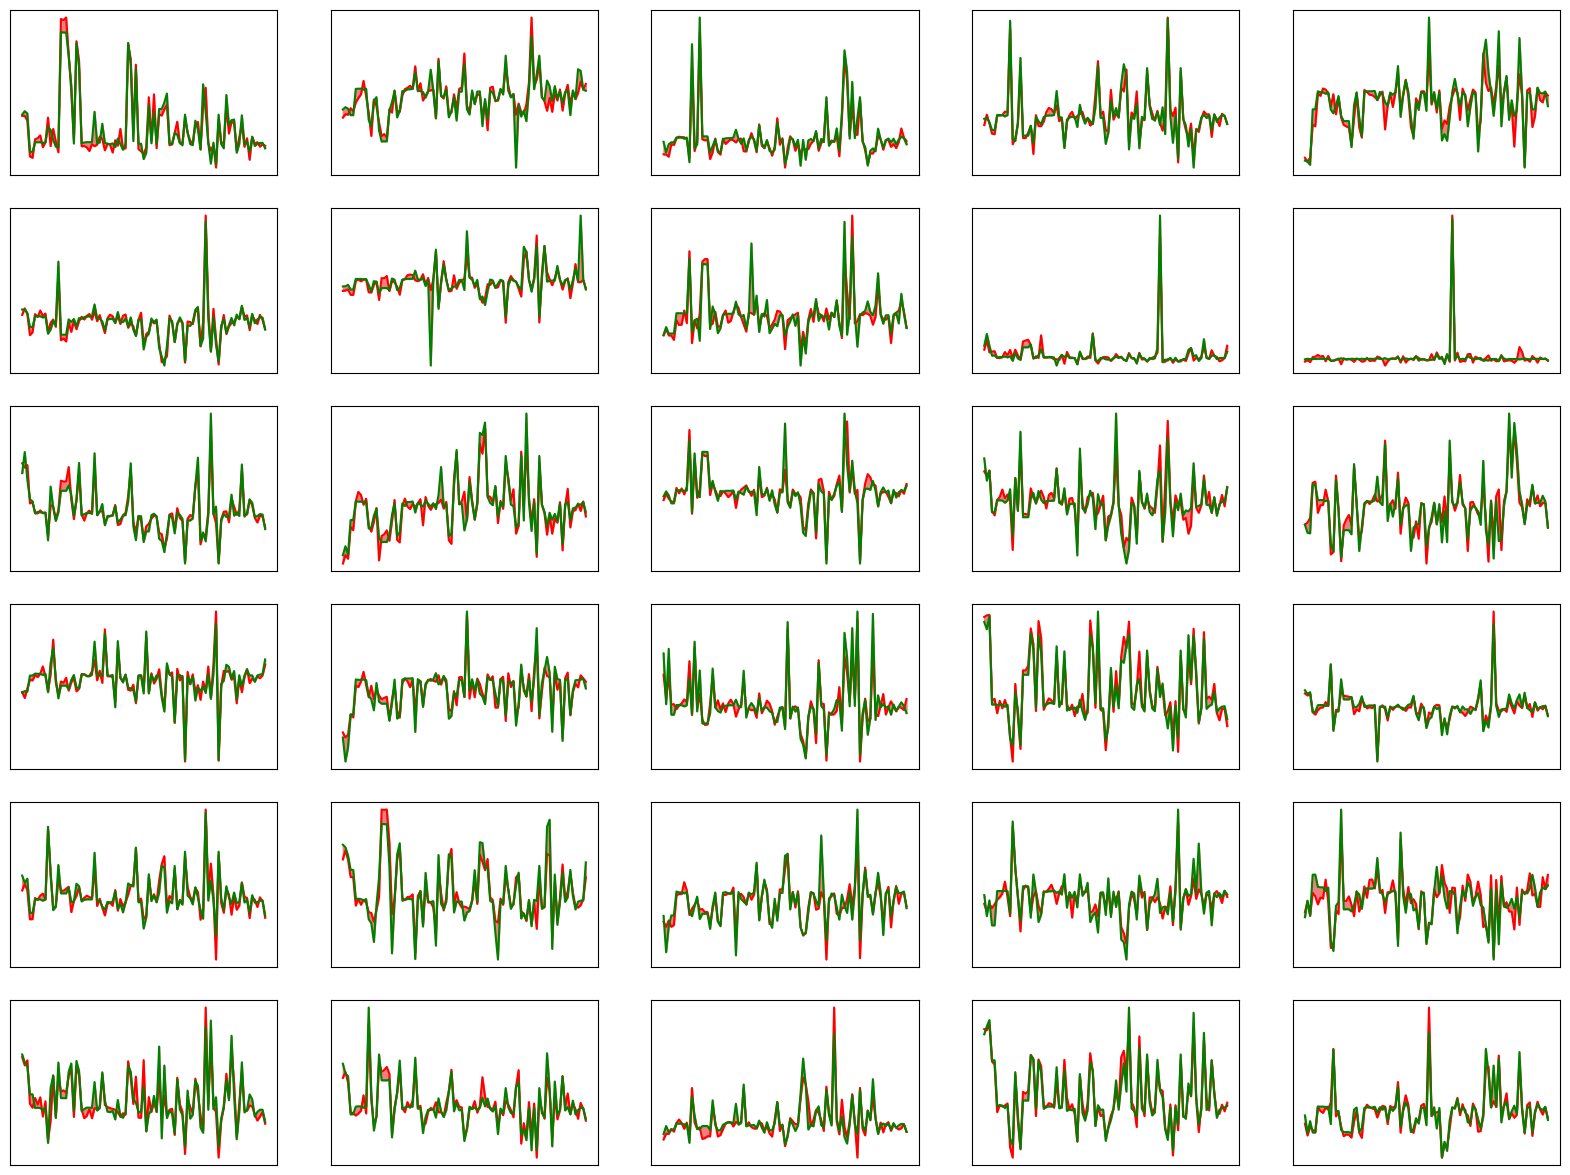

In [292]:
figure = plt.figure(figsize=(20, 15))
for label_index in range(30):
    ax = figure.add_subplot(6, 5, label_index + 1, xticks=[], yticks=[])
    ax.plot(reconstruction[label_index], 'r')
    ax.plot(X_test_normal[label_index], 'g')
    ax.fill_between(np.arange(X_test_normal.shape[1]), X_test_normal[label_index], reconstruction[label_index], color='lightcoral')

In [293]:
y_pred = np.where(classification[:,1] > 0.1, 1, 0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.34      0.34      0.34        44

    accuracy                           0.96      1364
   macro avg       0.66      0.66      0.66      1364
weighted avg       0.96      0.96      0.96      1364



In [294]:
def balance_bag (X, y, rate = 1):
    y_np = np.array(y)
    X_np = np.array(X)
    minor_label = np.copy(y_np[y_np == 1])
    minor_data = np.copy(X_np[y_np == 1])
    major_label = np.copy(y_np[y_np == 0])
    major_data = np.copy(X_np[y_np == 0])

    idx = np.random.permutation(major_data.shape[0])
    major_data, major_label = major_data[idx], major_label[idx]

    window = minor_data.shape[0] * rate

    list_bag = []
    itr = 0
    while (itr + window < major_data.shape[0]):
        sub = np.copy(major_data[itr: itr+window])
        sub = np.vstack((sub, minor_data))
        sub_label = np.copy(major_label[itr: itr+window])
        sub_label = np.hstack((sub_label, minor_label))

        idx = np.random.permutation(sub.shape[0])
        sub, sub_label = sub[idx], sub_label[idx]

        list_bag.append((sub, sub_label))
        itr += window

    return(list_bag)

bag_of_sub_data = balance_bag(X_train_normal, y_train, 1)
len(bag_of_sub_data)

29

In [295]:
list_of_models = []
for data in bag_of_sub_data:
    svae_ = SVAE((95,), 20, 95, 2)
    svae_.compile(optimizer='adam', metrics=['mse'])
    history = svae_.fit(data[0], data[1], epochs=10,)
    list_of_models.append(svae_)

Epoch 1/10
11/11 [==============================] - 3s 17ms/step - mse: 2.9397 - loss: 1.8912
Epoch 2/10
11/11 [==============================] - 0s 15ms/step - mse: 2.5696 - loss: 1.4750
Epoch 3/10
11/11 [==============================] - 0s 15ms/step - mse: 2.3771 - loss: 1.3738
Epoch 4/10
11/11 [==============================] - 0s 15ms/step - mse: 16839.3711 - loss: 7718.2637
Epoch 5/10
11/11 [==============================] - 0s 15ms/step - mse: 1.8338 - loss: 0.9957
Epoch 6/10
11/11 [==============================] - 0s 15ms/step - mse: 1.5620 - loss: 0.8624
Epoch 7/10
11/11 [==============================] - 0s 15ms/step - mse: 1.4777 - loss: 0.8582
Epoch 8/10
11/11 [==============================] - 0s 15ms/step - mse: 1.6013 - loss: 0.9493
Epoch 9/10
11/11 [==============================] - 0s 15ms/step - mse: 1.3564 - loss: 0.7940
Epoch 10/10
11/11 [==============================] - 0s 15ms/step - mse: 1.2395 - loss: 0.6854
Epoch 1/10
11/11 [==============================] - 

In [296]:
hard_voting = np.zeros(y_test.shape)
for model in list_of_models:

    mean, logvar = svae_.encode(X_test_normal)
    z = svae_.reparameterize(mean, logvar)
    classification = svae_.rep_mlp(z)
    y_pred = np.where(classification[:,1] > 0.5, 1, 0)

    hard_voting += y_pred
    
hard_voting /= len(list_of_models)

In [297]:
np.unique(hard_voting, return_counts=True)

(array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
        0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
        0.34482759, 0.37931034, 0.4137931 , 0.51724138, 0.55172414,
        0.5862069 , 0.62068966, 0.65517241, 0.68965517, 0.72413793,
        0.75862069, 0.79310345, 0.82758621, 0.86206897, 0.89655172,
        0.93103448, 0.96551724, 1.        ]),
 array([1120,   20,   12,    3,    4,    2,    3,    5,    2,    2,    3,
           2,    5,    2,    3,    4,    3,    3,    2,    7,    5,    3,
           2,    4,    3,    7,    9,  124], dtype=int64))

In [298]:
y_pred = np.where(hard_voting > 0.5, 1, 0)

In [299]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.93      1320
           1       0.17      0.68      0.27        44

    accuracy                           0.88      1364
   macro avg       0.58      0.78      0.60      1364
weighted avg       0.96      0.88      0.91      1364

